# **Vizbud, a travel recommendation tool**



**Team 25**

**Team Members:**

Dylan Chow  
Fuad Khan  
Khoi Le  
Sunith Areng  

# **Introduction**

---



Vizbud is a travel recommendation tool that suggests points of interest (POIs) to its users for their vacation. The system suggests POIs to the user based on places visited by their friends/friends of friends with similar levels of travel preference. We implement our system based off the data from a social media platform called Gowalla. Specifically, the system will study the user’s preferences, friendship network and then suggest a few cities containing some of the spots that the user might want to visit next. 
	
This project we explore two different algorithms to achieve our goal. The first approach uses the traditional Collaborative Filtering method to recommend spots based on users in the entire social media dataset who are very similar to the user in terms of travel preferences/interests. Our second approach uses Graph Mining to recommend a city and its spots based on the user's friendship network who are socially similar to the user. Finally, we attempted to combine both approaches to recommend places based on users' friends that are socially similar and has simliar interest as the user. Detailed explanation on all the approaches will be later discussed in this report. 


# **Motivation**

---



Social Media plays a huge role for the tourists in choosing their next travel destination. It has become a common practice among the youth to look for places on social media before going out and exploring different locations. An article by CNBC shows the rise of hashtag travel being a common source through which the youth explore these locations. Often we are influenced to visit a place based on what we see on social media only to be disappointed on arrival. It is also possible that some of the pictures on social media are heavily edited to appear more attractive than they actually are in reality. In practice, social media suggestions or results for travel locations are sponsored through paid advertisers. In many cases it may not be very personalized and may not really be of benefit to a person who is looking for a unique experience. 

From our personal experiences, we tend to rely on travel suggestions based on our network of friends. We are inspired to visit places that have already built a reputation among our network. Through these recommendations, we generally aim to recreate the pleasant time experienced by our friends for ourselves.

Our project aims to recreate this practice through useful Machine Learning algorithms like Collaborative Filtering and Graph Mining. We would like to present our solution as a feature that could be potentially integrated into a social media website like Facebook or Instagram. We will utilize the user data and their preferences to match with their friends on the same social media with similar levels of interest and recommend a list of places that he or she can potentially find interesting.


# **Importing Modules:**  
First we will mount the necesssary modules and Google Drive.

In [ ]:
import pandas as pd
import numpy as np
import time
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
import math

# **Dataset Description**

---



The chosen dataset is based on a social media site called Gowalla. The source of the data can be found on this link: http://snap.stanford.edu/data/loc-gowalla.html.

We have downloaded the data and our work is contained in this Google drive link: https://drive.google.com/drive/folders/1gfxSZ3VM5sOYRjyN_5haIq1yNPBlQ_E7?usp=share_link



This dataset contains information about locations visited by users, frequency of their visit, check-ins, etc. The friendship network was collected by the public API of Gowalla consisting of 196,591 nodes and 950,327 edges. There are a total of 6,442,890 check-ins of these users over the period of Feb. 2009 - Oct. 2010. The chosen datasets are briefly explained here:

1. **gowalla_friendship.csv** contains all the edges that connect the users (nodes) in Gowalla. We used this information to recommend cities and spots to a user based on its mutuals’ activities and places they have visited. The edges in this dataset are undirected which means that if userid 1 knows userid2, then userid2 must also know userid1. 


2. **gowalla_spots_subset1.csv** contains the ‘id’ column that represents the placeid. The spot_category column classifies what type of location each entry fits in. We notice that the data has higher count numbers for users, check-ins, and photos for more specialized locations and lower counts for common, private, or insignificant locations.

3. **gowalla_checkins.csv** has the check-ins and ‘placeid’ information telling us where the user has checked in on a specific datetime. The idea is to use this data to recommend cities based on what users have already visited. 

4. **gowalla_spots_subset2.csv** contains the names of locations corresponding to their id and coordinates along with the city they are situated at.




## **Importing the dataset**

In [ ]:
friends = pd.read_csv('drive/MyDrive/MSCI 446 Project/gowalla_friendship.csv')
friends.head()

,userid1,userid2
0,1,63488
1,1,2
2,1,3
3,1,4
4,1,5


In [ ]:
spots1 = pd.read_csv('drive/MyDrive/MSCI 446 Project/gowalla_spots_subset1.csv')
spots1.head()

,id,created_at,lng,lat,photos_count,checkins_count,users_count,radius_meters,highlights_count,items_count,max_items_count,spot_categories
0,8904,2008-12-06T16:28:53Z,-94.607499,39.052318,0,114,21,35,0,10,10,"[{'url': '/categories/89', 'name': 'Craftsman'}]"
1,8932,2008-12-13T02:16:51Z,-97.254356,32.927662,2,67,48,75,0,6,10,"[{'url': '/categories/17', 'name': 'BBQ'}]"
2,8936,2008-12-14T22:08:39Z,-94.591995,39.053318,0,75,46,75,0,10,10,"[{'url': '/categories/103', 'name': 'Theatre'}]"
3,8938,2008-12-15T00:22:49Z,-94.590311,39.052824,38,438,94,50,10,10,10,"[{'url': '/categories/1', 'name': 'Coffee Shop'}]"
4,8947,2008-12-16T23:14:05Z,-122.029631,37.331880,91,3100,1186,200,20,10,10,"[{'url': '/categories/121', 'name': 'Corporate..."


In [ ]:
checkin = pd.read_csv('drive/MyDrive/MSCI 446 Project/gowalla_checkins.csv')
checkin.head()

,userid,placeid,datetime
0,1338,482954,2011-06-23T02:24:22Z
1,1338,580963,2011-06-22T14:23:03Z
2,1338,365256,2011-06-09T23:29:30Z
3,1338,89504,2011-05-22T15:54:30Z
4,1338,1267135,2011-05-21T16:51:13Z


In [ ]:
spots2 = pd.read_csv('drive/MyDrive/MSCI 446 Project/gowalla_spots_subset2.csv', dtype='str', encoding='us-ascii', encoding_errors='ignore')
# Dropping unnecessary columns from spots2 that won't be used in the project
spots2 = spots2.drop(columns = ["Unnamed: 5", "Unnamed: 6"])
spots2.head()

,id,lat,lng,name,city_state
0,9813,36.63150787,-121.9120216,Pacific Ocean,"Seaside, CA"
1,11981,40.6901729,-74.04549122,Refreshment Park,"New York, NY"
2,12455,36.64202212,-93.2849121,Mickey Gilley Theatre,"Branson, MO"
3,12455,36.64202212,-93.2849121,Mickey Gilley Theatre,"Branson, MO"
4,13810,42.54887938,-82.90276765,Jaword,"Clinton, MI"


## **Data Exploration:**

We ran some statements to check the size of our datasets.

In [ ]:
size_of_spot1 = spots1['id'].unique()
size_of_spot1.shape

(2724891,)

In [ ]:
size_of_checkin_placeid = checkin['placeid'].unique()
size_of_checkin_placeid.shape

(2844145,)

We can see that there is a difference of 119K placeIDs found in the checkin placeids that are missing in the location info of spots1.

In [ ]:
# To check if the missing placeids exist in spot2. 
missing_spots = spots2[spots2.id.isin(size_of_checkin_placeid)]
missing_spots

,id,lat,lng,name,city_state


We notice that checkin place ids do not exist in spots2 at all. Data in spots2 are completely independent of the spots1 and checkin data. Hence, we will not be using spots2 further in our project.

## **Data Cleaning and Preparation**

### **Appplying filters to reduce the dataset**

To reduce the runtime of our code, the following constraints are applied:

In [ ]:
# We are grouping the spots by userid to get the total number of checkins by each user
grouped_checkins  = checkin.groupby(['userid'] , as_index=False).count()
grouped_checkins  = grouped_checkins.rename(columns={'placeid': 'count_checkin'})
grouped_checkins = grouped_checkins.drop(columns = ["datetime"])
# grouped_checkins.head(5)

# We only look at users with more than 5 but less than 50 check-ins. In this context, check-in refers to the place visited by a user. This parameter was initially between 
# 100 and 200 as mentioned in our proposal but, because the runtime of the dataset was getting quite significant, we have decided to narrow it further. 
selected_users = grouped_checkins[(grouped_checkins.count_checkin >= 5) & (grouped_checkins.count_checkin <= 50)].userid.values 

# # We are reducing the number of spots to the spots visited by our filtered users
selected_spots = checkin[checkin.userid.isin(selected_users)]
selected_spots.shape
selected_spots.head(5)

,userid,placeid,datetime
2791,27506,332616,2010-10-30T10:50:37Z
2792,27506,32080,2010-09-25T13:26:58Z
2793,27506,1290090,2010-08-02T17:06:59Z
2794,27506,1120128,2010-08-01T10:28:38Z
2795,27506,445729,2010-08-01T09:34:09Z


On the spots dataframe, we are trying to reduce our recommendation options as we are trying to recommend spots for the users who has checked into these locations.

In [ ]:
spots_set = selected_spots['placeid'].unique()
spots_dataset = spots1[spots1.id.isin(spots_set)]
spots_dataset.shape

(897636, 12)

We will filter out for some common areas that we do not want to recommend for our customer. Doing so reduces the number of locations by two hundred thousands from before.

In [ ]:
common_areas = ['Corporate','Office', 'Home', 'Airport', 'Apparel', 'Diner'
                'Administration', 'Starbucks', 'Grocery', 'IKEA', 
                'Gas & Automotive', 'Nike', 'Hospital', 'High School',
                'Health', 'Fitness', 'Sandwiches', 'Wings', 'College',
                'McDonald', 'H&M', 'Apartment', 'Shoes', 'Lowe', 'Burgers',
                'Dormitory', 'Warehouse', 'Industrial', 'Old Navy', 'Coffee'
                'Condo', 'Subway', 'Verizon', 'Walmart', 'University', 'Target'
                'School', 'Cineplex', 'Courthouse', 'Dairy Queen',
                'Station', 'Bank', 'Financial', 'Government', 'Bakery'
                'Store', 'Terminal', 'Bakery', 'Rental', 'Drugstore',  'Pharmacy', 
                'Donuts', 'Bar', 'Dormitory', 'Ice Cream', 'Pub', 'Whole Foods',
                'Best Buy', 'Gas', 'Ferry', 'Department Store', 'Hardware Store',
                'Condo']
regex = '|'.join(common_areas)
mask = spots_dataset['spot_categories'].str.contains(regex, case=False)
spots_dataset = spots_dataset[~mask].reset_index(drop=True)
spots_dataset.shape

(603192, 12)

In [ ]:
spots_dataset.dtypes

id                    int64
created_at           object
lng                 float64
lat                 float64
photos_count          int64
checkins_count        int64
users_count           int64
radius_meters         int64
highlights_count      int64
items_count           int64
max_items_count       int64
spot_categories      object
dtype: object

### **Setting up Get Location Function**

In [ ]:
# import module
!pip install opencage
from opencage.geocoder import OpenCageGeocode

key = 'a1c1cccbb42e473e84a1e90d4998cdf6'

geocoder = OpenCageGeocode(key)

from time import sleep

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 KB 2.6 MB/s eta 0:00:00


The function below takes the dataframe and column names as input and finds the city, state and country for each of the spots.

In [ ]:
def get_location(df, col1, col2):
  sleep(1.01)
  for i, row in df.iterrows():
    Latitude = row[col1]
    Longitude = row[col2]
    location = geocoder.reverse_geocode(Latitude, Longitude)
    sleep(1.01)
    loc = location[0]['components']

    if 'ISO_3166-2' in loc:
      df.loc[i, 'Country_State'] = loc['ISO_3166-2'][0]
    else:
      df.loc[i, 'Country_State'] = None

    if 'city' in loc:
      df.loc[i, 'city'] = loc['city']
    else:
      if 'town' in loc:
        df.loc[i, 'city'] = loc['town']
      else:
        df.loc[i, 'city'] = None
    
  return df

### **Calculation of user frequency**

In [ ]:
df_checkins_locations = pd.merge(selected_spots[['userid','placeid']], spots_dataset['id'],left_on="placeid",right_on="id",how="left") 
df_checkins_locations = df_checkins_locations.dropna()
df_checkins_locations.head(5)

,userid,placeid,id
0,27506,332616,332616.0
1,27506,32080,32080.0
3,27506,1120128,1120128.0
5,27506,201349,201349.0
6,27506,95770,95770.0


In [ ]:
df_frequencies = df_checkins_locations.groupby(['userid', 'placeid'])["id"].count().reset_index(name="frequency")
df_frequencies.head(5)

,userid,placeid,frequency
0,15,8904,1
1,15,9073,1
2,15,9186,1
3,15,9591,1
4,15,10299,1


Each user is being connected to the spots they have checked in to and the details for that spot. It also shows how many times (frequency) the user has been to that spot. A point to note, the spots may be repeated for different users who have visited that spot.

In [ ]:
df_frequencies = pd.merge(df_frequencies, spots_dataset,left_on="placeid",right_on="id",how="left")
df_frequencies.head(5)

,userid,placeid,frequency,id,created_at,lng,lat,photos_count,checkins_count,users_count,radius_meters,highlights_count,items_count,max_items_count,spot_categories
0,15,8904,1,8904,2008-12-06T16:28:53Z,-94.607499,39.052318,0,114,21,35,0,10,10,"[{'url': '/categories/89', 'name': 'Craftsman'}]"
1,15,9073,1,9073,2009-02-07T01:47:24Z,-122.393725,37.795339,114,2654,1659,100,14,10,10,"[{'url': '/categories/60', 'name': 'Other - Ar..."
2,15,9186,1,9186,2009-02-13T05:07:28Z,-77.036594,38.897638,195,1603,1383,250,19,15,10,"[{'url': '/categories/166', 'name': 'Historic ..."
3,15,9591,1,9591,2009-03-19T14:05:12Z,-122.159772,37.447908,54,1418,525,150,0,10,10,"[{'url': '/categories/230', 'name': 'Apple Sto..."
4,15,10299,1,10299,2009-03-27T20:44:47Z,-122.029459,37.332401,16,1149,348,75,4,10,10,"[{'url': '/categories/64', 'name': 'Other - Fo..."


### **Creating Dataframe to store users friends and checked in locations**

Converting the user_list into a dataframe with each user against their friend list.

In [ ]:
df_user_friends = friends.groupby('userid1').userid2.apply(list).reset_index(name='friends_list') 
df_user_friends.head(5)

,userid1,friends_list
0,1,"[63488, 2, 3, 4, 5, 6, 7, 12, 2065, 18, 24, 25..."
1,2,"[131140, 1, 55298, 3, 4, 5, 6, 7, 11, 12, 9327..."
2,3,"[1, 2, 4, 5, 6, 7, 12, 18, 2315532, 29, 309765..."
3,4,"[1, 2, 3, 5, 6, 7, 12, 65553, 18, 24, 25, 29, ..."
4,5,"[1, 2, 3, 4, 6, 7, 11, 12, 1544536, 18, 397334..."


In [ ]:
df_user_spots = selected_spots.groupby('userid').placeid.apply(list).reset_index(name='place_list') 
df_user_spots.head(15)

,userid,place_list
0,15,"[7198013, 9591, 8947, 1050882, 14710, 9073, 27..."
1,37,"[355154, 355396, 355356, 62846, 2387533, 30010..."
2,45,"[7360178, 22370, 6563736, 37303, 34157, 32398]"
3,53,"[290022, 644423, 644423, 1541920, 290022, 1757..."
4,81,"[85577, 3142623, 128873, 6708957, 6591488, 670..."
5,93,"[17831, 20918, 9220, 15245, 180328, 180328, 15..."
6,112,"[7339546, 73968, 38943, 912615, 4056109, 38943..."
7,124,"[23526, 671451, 158375, 148143, 139400, 143881..."
8,140,"[731182, 731182, 34076, 731182, 731182, 731182..."
9,153,"[9247, 46556, 249470, 68431, 17600, 17600, 132..."


# **Machine Learning**

---



## **Rationale**


**Collaboartive Filtering:**

Collaborative Filtering (CF) will allow us to look for users in the entire dataset and find the most similar user to our chosen user based on their past checkin locations. The intuition behind CF is that if User A and User B has checked in to the same spot in the past then User A will like the other places visited by User B. This is based on the notion that both the users are similar and will continue to agree in the future.  
  
Hence, in our collaborative filtering approach we aim to recommend travel locations based on the users who has similar interest as our chosen user. 

  

**Graph Mining:**

In real world, a lot of the places visited by users are similar to their friends. Users usually seek recommendation from their friends for travel locations and other places of interest. A lot of the friend groups form on the idea that they share common interests. CF does not account for the social influence among users or networks of people wheras Graph Mining does.  
  
For this approach, we hope to recommend travel locations based on the spots visited by a users friends and friends of friends. 

## **Choosing a user**

Next, we need a list of users who satisfies our checkin criteria and also has more than 25 friends and less than 50 friends which is our next filtering requirement. We get an array.  We originally set a minimum of 10 friends in the project proposal, but we found that users with 10 friends did not yield enough data to effectively run our models. We will use this set to pick a random user for whom we are trying to recommend the locations.

We are selecting users with checkin count more than 40 and less than 50 to make sure that there is sufficient data for our recommendations.

In [ ]:
selected_set = grouped_checkins[(grouped_checkins.count_checkin >= 40) & (grouped_checkins.count_checkin <= 50)].userid.values 

df_selected_userlist = friends[friends.userid1.isin(selected_set)]
df_selected_userlist.shape

(174146, 2)

Similarly, to make sure that we have sufficient data for our recommendation we consider users with friend count between 25 and 50.

In [ ]:
friendlist = df_selected_userlist.groupby(['userid1'], as_index=False).count()
friendlist = friendlist[(friendlist.userid2 >=25) & (friendlist.userid2 <=50)].userid1.values
friendlist.shape

(1086,)

First we obtain a random user for whom we are going to recommend a spot. We will call this chosen_user_id as User A.  From the proposal, we wanted to do users with 10 to 50 checkins, but we found 10 to be too little for some of our models, so we now select a random user that has 40 to 50 checkins.

In [ ]:
# random_user_list = grouped_checkins[(grouped_checkins.count_checkin >= 40) & (grouped_checkins.count_checkin <= 50)].userid.values 
chosen_user_id = np.random.choice(friendlist)
print(len(friendlist))
chosen_user_id

1086


140682

## **Approach 1: Collaborative Filtering**

---



### **Theoretical overview of approach**

Collaborative filtering (CF) seeks to discover patterns of agreement among users’ ratings for items/locations. In this case - if a user has visited similar locations with some other users, they are likely to do the same in the future.

**Mathematical Formulation** : 
Let U be our set of users, L be our set of check-in locations,
and R be a user-location rating matrix based on frequency of check-in locations, where each entry r(i,j) is the frequency of user u(i) visiting location l(j) . For an entry r(i,j) = 0 (meaning that the user i hasn't visited location j), we wil attempt to predict the rating of u(i) to unvisited
location l(j) with the formula below : 
\begin{equation}
r_{i,j} = \frac{\sum_{u_k \in U,  k \neq i} \text{CosSim}(u_i, u_k) \cdot r_{k,j}}{\sum_{u_k \in U , k \neq i} \text{CosSim}(u_i, u_k)}
\end{equation}
where 
\begin{equation}
\text{CosSim}(u_i, u_k) = \frac{\sum_{l_j \in L} r_{i,j} \cdot r_{k,j}}{\sqrt{\sum_{l_j \in L} r_{i,j}^2} \cdot \sqrt{\sum_{l_j \in L} r_{k,j}^2}}
\end{equation}

After obtaining r(i,j) for each locations, we would like to calculate a final recommendation score for each location which add r(i,j) with the log of the product of the checkin_count of location j to the sum of the frequency of visits to that place by the top 50 most similar users to our chosen user. 

\begin{equation} \text{Let the list of top 50 most similar users to our chosen user be }  U_{50}, \text{we have}\end{equation}

\begin{equation}
score_{i,j} = r_{i,j} + log(checkincount_{j}⋅\sum_{u_k \in U_{50},  k \neq i} r_{k,j})
\end{equation}

Justification for log formula : We chose to use a log function, because the popularity of a location grows exponentially as people tend to get drawn to the crowd.  For example, Disneyland is going to have hundreds times more checkins than the local coffee shop. 

Our log function is the product between the total check-in count of a location, and sum of frequency of visits to that location by our top 50 most similar users because we want to recommend places that are both frequented by similar users and that are also popular (high check-in count)

### **Approach Overview**

Finding r(i,j) for all users and all locations would take a significantly long time, so we intend to just focus on a user i in our dataset and compute r(i,j) for all possible location j. 

**Firstly**, we intend to compute the cosine similarity between our user i and all other user k in the dataset - then finding the top 100 most similar users to our user i.

In this step, it's worth noting that if a user doesn't share any similar check-in locations with our user i, then their cosine similarity is 0 - because the cosine similarity formula has numerator of : \begin{equation}\sum_{l_j \in L} r_{i,j} \cdot r_{k,j}\end{equation}
So if user i and k don't share a similar location j, the product r(i,j)*r(k,j) will become 0. Thus, we won't have to consider users that don't share any similar check-in locations with our user i.

**Secondly**, we will find r(i,j) - likelihood our chosen user i would enjoy location j for all locations j. In this step, we will limit our locations dataset to places that the top 100 users have visited but our chosen user i hasn't visited.

**Lastly**, we will calculate a final recommendation score for each location j by adding r(i,j) - the likelihood of user A visiting a POI given that user has not visited that place - to the log of the product of the checkin_count of the spot to the sum of the frequency of the visits by the top 50 most similar users to our chosen user.

We will then sort the locations on the basis of their rating and recommend those spots for our chosen user


\begin{equation}
score_{i,j} = r_{i,j} + log(checkincount_{j}⋅\sum_{u_k \in U_{50},  k \neq i} r_{k,j})
\end{equation}

### **Finding list of users that share at least 1 check-in locations with our user**

In [ ]:
CF_time_st = time.time()

In [ ]:
# Finding the list of users that have travelled to the same place as our chosen users : 
# Finding all check-in locations that our user has gone to
spots_went_to = np.array(df_user_spots[df_user_spots["userid"] == chosen_user_id]["place_list"])
# Init. array of users
all_users = []
all_info = []
# For each spot, find people who have gone there 
for i in spots_went_to: 
  for spot in i : 
    user = df_frequencies[(df_frequencies["placeid"] == spot) & (df_frequencies["userid"] != chosen_user_id) & (df_frequencies["frequency"] >= 0)]["userid"].tolist()
    all_users.append(user)
    all_info.append({spot : user})
# Get only unique values of user id and flatten list of users from 2d to 1d array
final_all_users = [j for sub in all_users for j in sub]
all_users_final = set(final_all_users)
all_users_final

{2408452,
 147461,
 221190,
 139271,
 122888,
 2383882,
 139277,
 188434,
 2408466,
 344102,
 155698,
 98357,
 294970,
 106555,
 1630269,
 2293839,
 2326607,
 81,
 2342996,
 213080,
 93,
 98403,
 147555,
 344165,
 2400356,
 2408551,
 376936,
 98409,
 57450,
 139371,
 204911,
 2375791,
 2400374,
 2113662,
 147588,
 2384005,
 147595,
 303251,
 155798,
 153,
 98458,
 262299,
 2408607,
 1982624,
 155811,
 295076,
 2310313,
 2375849,
 2384042,
 174,
 2384047,
 155825,
 164018,
 2343092,
 2425020,
 65727,
 188608,
 188612,
 2384071,
 155848,
 164042,
 172239,
 2384081,
 2375894,
 131292,
 2400478,
 230,
 172262,
 131304,
 16614,
 98535,
 852206,
 147695,
 98544,
 2351345,
 16636,
 2367741,
 164098,
 155909,
 385288,
 295177,
 147726,
 155924,
 147735,
 123161,
 295,
 2384174,
 74034,
 1032498,
 155957,
 164153,
 1573178,
 147771,
 147772,
 155972,
 147780,
 326,
 147783,
 2376008,
 2376010,
 57681,
 352595,
 98646,
 155997,
 287074,
 2384235,
 2376044,
 369004,
 147820,
 2179441,
 2425208,
 

### **Creating the Cosine Similarity Function**

In [ ]:
# Function to calculate cosine similarity
def cosine_similarity(user_i, user_k): 
  # Find list of check-in locations that user i and k have checked in
  stuff1 = df_user_spots[df_user_spots["userid"] == user_i]["place_list"]
  stuff2 = df_user_spots[df_user_spots["userid"] == user_k]["place_list"]
  user_i_places = stuff1.tolist()
  user_k_places = stuff2.tolist()
  # Find list of check-in locations user i and k have in common
  similar_array = np.intersect1d(user_i_places, user_k_places)
  # If no similar check-in locations, this means no similarity
  if len(similar_array) == 0:
    return 0
  # If there are similar locations, find them and calculate similarity 
  else:
    # Init. numerator and denominator values variable
    sum_numerator = 0
    sum_user_1 = 0
    sum_user_2 = 0
    # Go through the similar checked in locations to find the numerator: 
    for i in similar_array:
      # Getting check-in frequency at those similar locations of both user i and k 
      r_user_1 = df_frequencies[(df_frequencies["userid"] == user_i) & (df_frequencies["placeid"] == i)]["frequency"].tolist()
      r_user_2 = df_frequencies[(df_frequencies["userid"] == user_k) & (df_frequencies["placeid"] == i)]["frequency"].tolist()
      # Validation check in case the returned values are empty
      if len(r_user_1) != 0 :
        r_user_1 = r_user_1[0]
      else:
        r_user_1 = 0
      if len(r_user_2) != 0 :
        r_user_2 = r_user_2[0]
      else:
        r_user_2 = 0
      # Finding numerator
      sum_numerator += r_user_1 * r_user_2
    # Finding the denominator now
    # Go through all checked in locations of user i
    for i in user_i_places[0] : 
      frequency = df_frequencies[(df_frequencies["userid"] == user_i) & (df_frequencies["placeid"] == i)]["frequency"].tolist()
      if len(frequency) != 0:
        frequency = frequency[0]
        sum_user_1 += frequency * frequency
    # Go through all checked in locations of user k 
    for i in user_k_places[0] :
      frequency = df_frequencies[(df_frequencies["userid"] == user_i) & (df_frequencies["placeid"] == i)]["frequency"].tolist()
      if len(frequency) != 0:
        frequency = frequency[0]
        sum_user_2 += frequency * frequency
    # Finding the cosine similarity 
    if ((sum_user_1 != 0) & (sum_user_2 != 0)):
      return sum_numerator / (math.sqrt(sum_user_1) * math.sqrt(sum_user_2))
    else : 
      return 0 

### **Getting top 50 most similar users to our chosen user**

In [ ]:
final_results = []
# Running cosine similarity function for all users in our already filtered all_users_final list
for i in all_users_final : 
  result = [i, cosine_similarity(chosen_user_id,i)]
  final_results.append(result)
# Creating a Data Frame that has user id and their cosine similarity result with our user
df = pd.DataFrame(final_results, columns=['User', 'Result'])


In [ ]:
df

,User,Result
0,2408452,0.158114
1,147461,0.387298
2,221190,0.158114
3,139271,0.353553
4,122888,0.158114
...,...,...
2212,2318326,0.158114
2213,114680,0.223607
2214,155641,0.158114
2215,638972,0.387298


In [ ]:
# Getting top 50 most similar users
top_50_users = df.sort_values(by=['Result'],ascending=False).head(50)
top_50_users_list = top_50_users["User"].tolist()
print(top_50_users_list)

[135786, 154475, 150461, 150586, 4669, 155379, 154412, 67813, 147926, 329781, 10361, 144724, 55721, 152485, 2388016, 2382928, 143770, 1992, 2099517, 153121, 139277, 2380242, 2155837, 2382622, 3736, 153663, 9015, 72660, 7080, 2380781, 29168, 281430, 121136, 112964, 140416, 2388539, 2380447, 98708, 152271, 2179441, 152302, 75636, 110348, 151331, 153821, 148559, 2378593, 139252, 150474, 2380645]


### **Finding r(i,j)**

Now that we have found the top 50 most similar users, let us find the list of locations to be recommneded for our chosen user. 

This list of locations will be all checked-in locations that those top 50 users have gone to, but our chosen user hasn't gone to.

In [ ]:
# Getting all checked-in locations that the top 50 users have been to
locations = []
for i in top_50_users_list:
  r_user_1 = df_frequencies[(df_frequencies["userid"] == i) & (df_frequencies["frequency"] > 0)]["placeid"].tolist()
  locations.append(r_user_1)
# Flatten this locations array
flatten_locations = [j for sub in locations for j in sub]
# Get unique values of this flattened array
unique_locations = list(set(flatten_locations))

# Getting all checked-in locations that our chosen user has been to 
our_user_locations = df_frequencies[(df_frequencies["userid"] == chosen_user_id) & (df_frequencies["frequency"] > 0)]["placeid"].tolist()

# Get final list of locations that the top 50 users have been to but our chosen user hasn't been to - so our list of locations to be recommended.
final_locations = [x for x in unique_locations if x not in our_user_locations]
print(final_locations)

[22535, 702472, 139273, 892939, 26635, 6887435, 6936591, 579600, 671762, 6887442, 6887443, 18452, 6936600, 30748, 6936604, 671776, 671777, 722978, 729121, 671781, 38949, 10279, 32823, 12344, 6887480, 671802, 61501, 1110079, 374848, 10305, 671807, 671812, 757838, 813141, 694359, 534615, 671834, 264284, 594019, 180328, 7055474, 6936696, 692344, 6936698, 7057531, 686208, 694404, 18565, 1357957, 518276, 712839, 6887558, 671886, 671888, 671889, 702615, 671896, 22682, 28829, 59551, 45216, 14496, 7063734, 348343, 35000, 671928, 346303, 6936771, 7205060, 28871, 1175759, 733398, 694487, 616669, 671967, 7051489, 7055594, 12526, 501998, 712947, 671988, 22781, 710911, 125184, 123137, 700671, 7078149, 33037, 475408, 672017, 712991, 694560, 672035, 14633, 133417, 5536046, 672046, 7145776, 715064, 1110329, 291132, 22847, 100674, 229700, 102727, 22858, 53585, 22865, 10577, 592213, 72025, 102748, 2273629, 24925, 18785, 665956, 6936933, 6936934, 20843, 672109, 43374, 672110, 18800, 6938990, 92535, 10878

With both the list of the top 50 most similar users and list of all locations to be recommended to our chosen user - we are now ready to compute r(i,j) : the likelihood that our user i will enjoy or go to location j. We would compute r(i,j) for all j in our list of final_locations.

But firstly, let us calculate the denominator of all r(i,j) - which is the sum of all cosine similarity between our user i and the other 50 users.

In [ ]:
# sum of all cosine similarity between our user i and the other 50 users.
df_50_users = df.sort_values(by=['Result'],ascending=False).head(50)
denominator = df_50_users["Result"].sum()
df_50_users.head(5)

,User,Result
1268,135786,0.651920
1920,154475,0.591608
819,150461,0.570088
846,150586,0.547723
1254,4669,0.524404


In [ ]:
array_of_i_j = []
# We loop through every location j in our locations list to find r(i,j) for each of them
for j in final_locations :
  # Init. r(i,j)
  r_i_j = 0
  numerator = 0
  # Loop through all user k in our top 50 users list to find r(k,j) times cosine similarity(chosen user i, user k)
  for k in top_50_users_list :
    # Finding r(k,j) - frequency that user k has gone to location j
    r_k_j = df_frequencies[(df_frequencies["userid"] == k) & (df_frequencies["frequency"] > 0) & (df_frequencies["placeid"] == j)]["frequency"].tolist()
    # Validation in case of empty return 
    if len(r_k_j) == 0 :
      r_k_j = 0
    else : 
      r_k_j = r_k_j[0]
      # Getting cosine similarity between our chosen user i and user k
      similarity_i_k = df_50_users[df_50_users["User"] == k]["Result"].tolist()[0]
      # Adding the product between r(k,j) and our cosine similarity to our numerator
      numerator += (r_k_j*similarity_i_k)
  # After the 2 loops have run, we can now find r(i,j)
  r_i_j = numerator / denominator
  array_of_i_j.append([j,r_i_j])
  # print([j,r_i_j])
# Creating a Data Frame with the location j id and their calculated r(i,j) value
dataframe_i_j = pd.DataFrame(array_of_i_j, columns=['Location', 'Result'])
dataframe_i_j


,Location,Result
0,22535,0.022540
1,702472,0.057592
2,139273,0.020388
3,892939,0.022540
4,26635,0.019222
...,...,...
648,7067634,0.020388
649,450548,0.053943
650,722936,0.017981
651,708601,0.044892


### **Results using Collaborative Filtering**

In [ ]:
# Getting the top 10 most similar values
top_10_locations = dataframe_i_j.sort_values(by=['Result'],ascending=False).head(10)
top_10_locations

,Location,Result
319,9222,0.389829
381,9379,0.374898
331,9249,0.258523
29,10305,0.252994
345,6745159,0.226579
607,200571,0.224170
355,9313,0.216936
323,9227,0.212184
91,694560,0.210135
164,672270,0.199548


Next we want to account for the check-in counts of each of the top 10 locations into our POI_score. To do so, we will get the sum of the frequencies of visit by the similar users for each of the locations.

In [ ]:
top_loc_arr = top_10_locations['Location'].values
# top_loc_arr

temp1 = df_frequencies[df_frequencies.placeid.isin(top_loc_arr)]
temp1 = temp1[temp1.userid.isin(top_50_users_list)]
temp1 = temp1.groupby('placeid')['frequency'].sum().reset_index()
temp1 = temp1[['placeid','frequency']]
temp1

,placeid,frequency
0,9222,19
1,9227,11
2,9249,13
3,9313,11
4,9379,17
5,10305,12
6,200571,8
7,672270,10
8,694560,10
9,6745159,12


Finally we combine the similarity results and the sum of frequencies of visits by similar users for the POIs with its details. We then run the get location function to get the name of the city, state and country of these locations.

In [ ]:
temp2 = pd.merge(spots_dataset, temp1, left_on="id",right_on="placeid",how="right")
recom_POI = pd.merge(temp2, top_10_locations, left_on="placeid",right_on="Location",how="right")
recom_POI = get_location(recom_POI, 'lat', 'lng')

We calculate POI_score which is the sum of the r(i,j) and the log of the sum of the frequency of visits times the total check-ins to that spot.

In [ ]:
recom_POI = recom_POI[['placeid', 'frequency', 'lat', 'lng', 'spot_categories','checkins_count', 'users_count', 'city','Country_State', 'Result']]
recom_POI['POI_score'] = recom_POI['Result'] + np.log(recom_POI['checkins_count']*recom_POI['frequency']) / np.log(1000)

<ipython-input-36-35432ccb7d34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recom_POI['POI_score'] = recom_POI['Result'] + np.log(recom_POI['checkins_count']*recom_POI['frequency']) / np.log(1000)


Finally sort the results by the POI_score and calculate the probabilty of the user travelling to that location among the other recommended places.

In [ ]:
rec_denom = recom_POI['POI_score'].sum()
recom_POI['Probability%'] = recom_POI['POI_score']*100/rec_denom
recom_POI = recom_POI.sort_values(by='POI_score', ascending=False)
recom_POI

<ipython-input-37-a3be1b88e4b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recom_POI['Probability%'] = recom_POI['POI_score']*100/rec_denom


,placeid,frequency,lat,lng,spot_categories,checkins_count,users_count,city,Country_State,Result,POI_score,Probability%
0,9222,19,30.268158,-97.741660,"[{'url': '/categories/49', 'name': 'Luxury Hot...",4423,2739,Austin,US-TX,0.389829,2.031320,11.965854
1,9379,17,30.268973,-97.740383,"[{'url': '/categories/49', 'name': 'Luxury Hot...",1645,622,Austin,US-TX,0.374898,1.857103,10.939600
4,6745159,12,30.265072,-97.747550,"[{'url': '/categories/370', 'name': 'Party'}]",5422,3835,Austin,US-TX,0.226579,1.831026,10.785991
7,9227,11,30.268519,-97.736177,"[{'url': '/categories/17', 'name': 'BBQ'}]",5953,3781,Austin,US-TX,0.212184,1.817561,10.706668
2,9249,13,30.267254,-97.739444,"[{'url': '/categories/15', 'name': 'Mexican'}]",3262,2371,Austin,US-TX,0.258523,1.800999,10.609107
3,10305,12,30.269555,-97.742207,"[{'url': '/categories/103', 'name': 'Theatre'}]",3180,1808,Austin,US-TX,0.252994,1.780197,10.486572
6,9313,11,30.268696,-97.745615,"[{'url': '/categories/26', 'name': 'Ultra-loun...",3505,2426,Austin,US-TX,0.216936,1.745630,10.282947
9,672270,10,30.263515,-97.740169,"[{'url': '/categories/285', 'name': 'Interacti...",643,615,Austin,US-TX,0.199548,1.468952,8.653125
8,694560,10,30.264148,-97.739286,"[{'url': '/categories/243', 'name': 'Conventio...",370,294,Austin,US-TX,0.210135,1.399536,8.244219
5,200571,8,33.758830,-84.348937,"[{'url': '/categories/1', 'name': 'Coffee Shop'}]",143,40,Atlanta,US-GA,0.224170,1.243645,7.325916


We can see that the results are strictly based on the same city and country. This is because a user will have more cosine similarity with another user who has checked into the same location as them. The similarity increases as user has more common checkin locations with another user. Hence, Collaborative Filtering mostly recommends local spots.

In [ ]:
CF_time_et = time.time()
CF_elapsed_time = CF_time_et - CF_time_st
CF_elapsed_time

1150.4052639007568

## **Approach 2: Graph Mining**

---



### **Theoretical overview of approach**


**Mathematical Formulation** : 
Let U be our set of users, L be our set of check-in locations,
and R be a user-location rating matrix based on frequency of check-in locations, where each entry r(i,j) is the frequency of user u(i) visiting location l(j) . For an entry r(i,j) = 0 (meaning that the user i hasn't visited location j), we wil attempt to predict the rating of u(i) to unvisited
location l(j) with the formula below : 
\begin{equation}
r_{i,j} = \frac{\sum_{u_k \in U,  k \neq i} \text{SocSim}(u_i, u_k) \cdot r_{k,j}}{\sum_{u_k \in U , k \neq i} \text{SocSim}(u_i, u_k)}
\end{equation}
where 
\begin{equation}
\text{SocSim}(u_i, u_k) = \frac{\left\lvert \text{F}(u_i) \cap \text{F}(u_k) \right\rvert}{\left\lvert \text{F}(u_i) \cup \text{F}(u_k) \right\rvert}
\end{equation}

After obtaining r(i,j) for each locations, we would like to calculate a final recommendation score for each location which add r(i,j) with the log of the product of the checkin_count of location j to the sum of the frequency of visits to that place by the top 50 most similar users to our chosen user. 

\begin{equation} \text{Let the list of top 50 most similar users to our chosen user be }  U_{50}, \text{we have}\end{equation}

\begin{equation}
score_{i,j} = r_{i,j} + log(checkincount_{j}⋅\sum_{u_k \in U_{50},  k \neq i} r_{k,j})
\end{equation}

Justification for log formula : We chose to use a log function, because the popularity of a location grows exponentially as people tend to get drawn to the crowd.  For example, Disneyland is going to have hundreds times more checkins than the local coffee shop. 

Our log function is the product between the total check-in count of a location, and sum of frequency of visits to that location by our top 50 most similar users because we want to recommend places that are both frequented by similar users and that are also popular (high check-in count)

### **Appoach Overview**

Instead of Cosine Similarity to find the most similar user, we will recommend based on social similarity. Basic implementation details:
1. First we look at User A's list of friends and pick a friend B.
2. We find out how similar A and B are through their list of mutual friends. If they have too many mutual friends then they are similar.
3. Based on this, we look at POIs visited by user B.
4. We make sure the POIs visited by user B were not visited by user A.
5. We calculate a score for the POI by adding likelihood of user A visitng a POI given that user has not visited that place to the log of the product of the checkin_count of the spot to the frequency of the visits by our top 50 most similar users.
6. Sort the POIs on the basis of their rating and recommend those spots for the user A.

In [ ]:
GM_time_st = time.time()

In [ ]:
user_friendslist = df_user_friends[df_user_friends.userid1 == chosen_user_id].friends_list.values[0]

In [ ]:
import networkx as nx
import random

Now we just want to visualize the social network our user. In interest of time, we will only show the friend network of our chosen user and 2 of their friends. These two friends are chosen randomly.

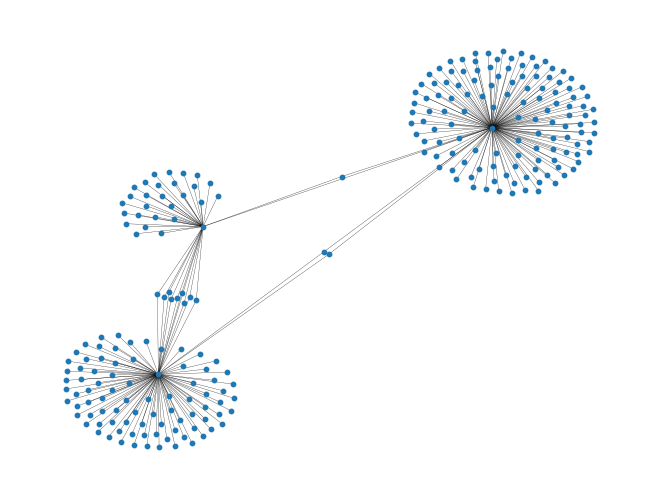

In [ ]:
visuals = user_friendslist.copy()
# visuals.append(chosen_user_id) 
samp1 = random.sample(visuals, 2)
user = [chosen_user_id]

for i in samp1:
  user.append(i)

edges = friends[friends.userid1.isin(user)]
G = nx.from_pandas_edgelist(edges,source='userid1', target='userid2')
nx.draw(G, width=0.2, node_size=10)

### **Social Similarity Function**

Then we create a function to calculate the social similarity of the user A to another user B

In [ ]:
# This function calculates the social similary between two users A and B
def social_similarity(A, B):
    # friends of de A
    list1 = df_user_friends[df_user_friends.userid1 == A].friends_list.values[0]
    # friends of B
    list2 = df_user_friends[df_user_friends.userid1 == B].friends_list.values[0]
    sim = len(list(set(list1) & set(list2))) / len(list(set(list1) | set(list2)))

    return sim

In [ ]:
user_sim = pd.DataFrame(columns=['userA', 'userB', 'similarity'])

We will create a function that will take in the empty dataframe that we just created as its input along with the user for whom we want to recommend a POI. This function will look at the list of friends of the user A and call the social similarity function to calculate their similarities. We nest another loop where we look at the friend of the friend and check their similarity to the user A.

### **Defining Graph Mining Function**

In [ ]:
def graph_mining(user_sim, user):
  user_sim.drop(user_sim.index, inplace=True)
  for i in user_friendslist:
    # comparing for a user and their friends
    similarity = social_similarity(user, i)
    row_data = {
          'userA': user,
          'userB': i,
          'similarity': similarity
      }
    user_sim = pd.concat([user_sim, pd.DataFrame(row_data, index=[0])], ignore_index=True)
    
    # To compute for their friends of friends
    fof = df_user_friends[df_user_friends.userid1 == i].friends_list.values[0]
    for j in fof:
      similarity = social_similarity(user, j)
      row_data = {
          'userA': user,
          'userB': j,
          'similarity': similarity
      }
      user_sim = pd.concat([user_sim, pd.DataFrame(row_data, index=[0])], ignore_index=True)

  user_sim = user_sim.drop_duplicates(subset='userB')
  return user_sim

In [ ]:
user_sim = graph_mining(user_sim, chosen_user_id)

### **Obtaining top socially similar users**

For our results we want to sort users with whom our user A is most similar (ascending order). Then we will select a small subset 'top friends' that are most similar to user A. We make sure to remove the top entry as the top entry is the user A himself since they appear as a common person when being looked as 'friend of friend'.

In [ ]:
results = user_sim.sort_values(by='similarity', ascending=False)

# Removing row where our user A is compared against themselves i.e. social simlarity will be 1
userA_idx = results[results['userA'] == results['userB']].index.values[0]
results = results.drop(userA_idx)

# Picking the the top 50 socially similar users
top_friends = results.head(50)
top_friends['userA'] = top_friends['userA'].astype(int)
top_friends['userB'] = top_friends['userB'].astype(int)
print(top_friends.shape)
top_friends.head(5)

(50, 3)


<ipython-input-47-84cfb50ef723>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_friends['userA'] = top_friends['userA'].astype(int)
<ipython-input-47-84cfb50ef723>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_friends['userB'] = top_friends['userB'].astype(int)


,userA,userB,similarity
2844,140682,153996,0.173913
1719,140682,81978,0.145833
2995,140682,392579,0.122449
1668,140682,139371,0.113208
6082,140682,848817,0.111111


Then we filter our larger dataset with the spots info into a smaller one. We only need the places that have been visited by the people who are most similar socially to our user A.

Next, we will find the places that have been visited by the user A. We will use this series to remove the suggested addresses that have been already visited by the user A. This makes sure that we are suggesting a new spot to our user.

Finally, we call the get_location function on our selected location to get their city, country and state information.

In [ ]:
# Getting the places visited by the socially simliar users
tp_fd = top_friends['userB'].values
suggested_spots = df_frequencies[df_frequencies.userid.isin(tp_fd)]

user_placelist = df_user_spots[df_user_spots.userid == chosen_user_id]['place_list'].values[0]
# We delete the places visited by our user A from the suggested spots
df_spots_address = suggested_spots[~suggested_spots.placeid.isin(user_placelist)]

### **Finding r(i,j)**

rij is the likelihood rating of the user visiting a POI given how often the people similar to the user A has visited that place

In [ ]:
# Getting a list of all the suggested locations
final_locations = df_spots_address['placeid'].values
denominator = top_friends['similarity'].sum()

In [ ]:
array_of_i_j = []
for j in final_locations :
  r_i_j = 0
  numerator = 0
  for k in tp_fd :
    r_k_j = df_frequencies[(df_frequencies["userid"] == k) & (df_frequencies["frequency"] > 0) & (df_frequencies["placeid"] == j)]["frequency"].tolist()
    if len(r_k_j) == 0 :
      r_k_j = 0
    else : 
      r_k_j = r_k_j[0]
      similarity_i_k = top_friends[top_friends["userB"] == k]['similarity'].tolist()[0]
      numerator += (r_k_j*similarity_i_k)
  r_i_j = numerator / denominator
  array_of_i_j.append([j,r_i_j])
  # print([j,r_i_j])
dataframe_i_j = pd.DataFrame(array_of_i_j, columns=['Location', 'Result'])
dataframe_i_j.head(5)

,Location,Result
0,9510,0.021181
1,9529,0.021181
2,13453,0.021181
3,15537,0.082746
4,22576,0.021181


### **Results using Graph Mining**

We then get top 10 places visited by the socially similar users based on the order of how likely user A will visit the places visited by their friends.

We are removing duplicate locations from the list to get the top 10 locations.

In [ ]:
top_10_graph_mining = dataframe_i_j.sort_values(by=['Result'],ascending=False).drop_duplicates()
top_10_graph_mining = top_10_graph_mining.head(10)
top_10_graph_mining

,Location,Result
49,7062076,0.186636
80,15245,0.154662
32,657091,0.147695
47,4555135,0.130645
168,37156,0.106733
33,966233,0.098463
103,15537,0.082746
25,25175,0.073847
116,1101681,0.060946
107,10305,0.054854


We will then calculate the sum of the frequency of visits to the above locations by the simliar users.

In [ ]:
top_loc_gm = top_10_graph_mining['Location'].values

gm_temp1 = df_frequencies[df_frequencies.placeid.isin(top_loc_gm)] 
# top_loc_gm is the list of locations suggested for our user based on r(i,j) value

gm_temp1 = gm_temp1[gm_temp1.userid.isin(tp_fd)] 
# tp_fd is the list of similar friends to our user

gm_temp1 = gm_temp1.groupby('placeid')['frequency'].sum().reset_index()
gm_temp1 = gm_temp1[['placeid','frequency']]
gm_temp1

,placeid,frequency
0,10305,3
1,15245,6
2,15537,4
3,25175,3
4,37156,5
5,657091,6
6,966233,4
7,1101681,2
8,4555135,7
9,7062076,10


In [ ]:
# We are getting the frequency of the similar users visitng the location
gm_temp2 = pd.merge(spots_dataset, gm_temp1, left_on="id",right_on="placeid",how="right")

# We are getting the Result (rating) of the user visiting the spot for each of the POI
gm_temp3 = pd.merge(gm_temp2, top_10_graph_mining, left_on="placeid",right_on="Location",how="right")
tt = get_location(gm_temp3, 'lat', 'lng')
tt

,id,created_at,lng,lat,photos_count,checkins_count,users_count,radius_meters,highlights_count,items_count,max_items_count,spot_categories,placeid,frequency,Location,Result,Country_State,city
0,7062076,2011-03-12T18:39:44Z,-97.718282,30.314654,1,17,5,100,0,0,10,"[{'url': '/categories/55', 'name': 'Other - Pa...",7062076,10,7062076,0.186636,US-TX,Austin
1,15245,2009-06-13T18:28:15Z,-97.733098,30.264433,76,1986,755,50,18,10,10,"[{'url': '/categories/1', 'name': 'Coffee Shop'}]",15245,6,15245,0.154662,US-TX,Austin
2,657091,2010-03-06T20:57:31Z,-97.771304,30.275237,55,1490,436,150,7,11,10,"[{'url': '/categories/55', 'name': 'Other - Pa...",657091,6,657091,0.147695,US-TX,Austin
3,4555135,2010-09-27T21:25:08Z,-97.746756,30.265174,368,2045,1307,150,7,10,10,"[{'url': '/categories/32', 'name': 'Live Music'}]",4555135,7,4555135,0.130645,US-TX,Austin
4,37156,2009-10-04T23:22:14Z,-97.756765,30.246453,118,1472,627,75,19,10,10,"[{'url': '/categories/1', 'name': 'Coffee Shop'}]",37156,5,37156,0.106733,US-TX,Austin
5,966233,2010-04-18T02:51:16Z,-118.255808,34.052874,8,323,176,75,0,5,10,"[{'url': '/categories/49', 'name': 'Luxury Hot...",966233,4,966233,0.098463,US-CA,Los Angeles
6,15537,2009-06-19T02:06:50Z,-97.736961,30.266583,31,693,594,75,1,10,10,"[{'url': '/categories/15', 'name': 'Mexican'}]",15537,4,15537,0.082746,US-TX,Austin
7,25175,2009-09-16T18:47:45Z,-97.832029,30.296321,23,484,156,75,1,10,10,"[{'url': '/categories/1', 'name': 'Coffee Shop'}]",25175,3,25175,0.073847,US-TX,None
8,1101681,2010-05-12T00:01:37Z,-97.741502,30.267077,0,23,23,75,0,1,10,"[{'url': '/categories/373', 'name': 'Meet Up'}]",1101681,2,1101681,0.060946,US-TX,Austin
9,10305,2009-03-27T22:07:21Z,-97.742207,30.269555,206,3180,1808,100,20,10,10,"[{'url': '/categories/103', 'name': 'Theatre'}]",10305,3,10305,0.054854,US-TX,Austin


Calculating POI_score based accounting for the total checkins to the POI by the entire population

In [ ]:
tt = tt[['placeid', 'frequency', 'lat', 'lng', 'spot_categories','checkins_count', 'users_count', 'city','Country_State', 'Result']]
tt['POI_score'] = tt['Result'] + np.log(tt['checkins_count']*tt['frequency']) / np.log(1000)

<ipython-input-54-a939ea572078>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt['POI_score'] = tt['Result'] + np.log(tt['checkins_count']*tt['frequency']) / np.log(1000)


Calculating the Probability % for the top 10 locations

In [ ]:
rec_denom = tt['POI_score'].sum()
tt['Probability%'] = recom_POI['POI_score']*100/rec_denom

<ipython-input-55-e62ee96f14b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt['Probability%'] = recom_POI['POI_score']*100/rec_denom


Now we get the final results:

In [ ]:
final_suggestions = tt.sort_values(by='POI_score', ascending=False)
final_suggestions

,placeid,frequency,lat,lng,spot_categories,checkins_count,users_count,city,Country_State,Result,POI_score,Probability%
3,4555135,7,30.265174,-97.746756,"[{'url': '/categories/32', 'name': 'Live Music'}]",2045,1307,Austin,US-TX,0.130645,1.515909,14.461157
1,15245,6,30.264433,-97.733098,"[{'url': '/categories/1', 'name': 'Coffee Shop'}]",1986,755,Austin,US-TX,0.154662,1.513372,15.085890
2,657091,6,30.275237,-97.771304,"[{'url': '/categories/55', 'name': 'Other - Pa...",1490,436,Austin,US-TX,0.147695,1.464807,14.630134
4,37156,5,30.246453,-97.756765,"[{'url': '/categories/1', 'name': 'Coffee Shop'}]",1472,627,Austin,US-TX,0.106733,1.395692,14.874060
9,10305,3,30.269555,-97.742207,"[{'url': '/categories/103', 'name': 'Theatre'}]",3180,1808,Austin,US-TX,0.054854,1.381370,11.932802
6,15537,4,30.266583,-97.736961,"[{'url': '/categories/15', 'name': 'Mexican'}]",693,594,Austin,US-TX,0.082746,1.230344,14.180354
5,966233,4,34.052874,-118.255808,"[{'url': '/categories/49', 'name': 'Luxury Hot...",323,176,Los Angeles,US-CA,0.098463,1.135551,10.102560
7,25175,3,30.296321,-97.832029,"[{'url': '/categories/1', 'name': 'Coffee Shop'}]",484,156,None,US-TX,0.073847,1.127836,14.764672
0,7062076,10,30.314654,-97.718282,"[{'url': '/categories/55', 'name': 'Other - Pa...",17,5,Austin,US-TX,0.186636,0.930119,16.501111
8,1101681,2,30.267077,-97.741502,"[{'url': '/categories/373', 'name': 'Meet Up'}]",23,23,Austin,US-TX,0.060946,0.615198,11.368915


Unlike Collaborative Filtering, here we see that locations are more varied. They are situated in different parts of the country/world. In reality, while it may be possible but we do not expect a user to go too far away from their past checked-in locations. So Graph Mining results will work for a user who likes to travel around the world.

In [ ]:
GM_time_et = time.time()
GM_elapsed_time = GM_time_et - GM_time_st
GM_elapsed_time

164.8797516822815

## **Approach 3: Combination of Collaborative Filtering and Graph Mining**

### **Approach Overview**

We would like to create a third approach that combines the best of both the approaches disccused above. Firstly, we will use graph mining to obtain similar users from the list of our chosen user's friends and friends of friends.

Secondly, we would use the collaborative filtering to obtain the cosine similarity of these users. These users are user's friends who checked into the same location as our user.

Lastly, the top 50 users with the highest cosine similarity will now be obtained as the user list of interest. We will then calculate r(i,j) - likelihood our chosen user i would enjoy location j for all locations j, with j being all places that the top 50 users have visited but our chosen user i hasn't visited.

**Assumption** : This approach will only work when at least 1 friend / friends of friends has at least 1 shared check-in location, because only then would the cosine similarity between them be larger than zero. 

### **Graph Mining**

In [ ]:
A3_time_st = time.time()

In [ ]:
# Getting list of our chosen user friends and their friends that has social similarity value that's non-zero
friend_and_friends_list = results[results["similarity"] > 0]["userB"].tolist()

In [ ]:
# Getting list of users that share at least 1 check-in location with our chosen user
# all_users_final

### **Collaborative Filtering**

In [ ]:
# Getting list of people in our user friend/their friends list that also share at least 1 check-in location with our chosen user
common_people_list = [item for item in friend_and_friends_list if item in all_users_final]
common_people_list

[139371,
 54213,
 153799,
 373755,
 141675,
 169463,
 160500,
 132780,
 58911,
 98646,
 188902,
 57160,
 2483806,
 1606802,
 2261386,
 212184,
 115951,
 160818,
 127849,
 159469,
 151374,
 2218313,
 153,
 2226231,
 158015,
 153125,
 144163,
 366740,
 2512145,
 68274,
 129639,
 2673981,
 61871,
 174249,
 227789,
 2375791,
 981799,
 2549813,
 150537,
 2523027,
 130198,
 293321,
 2404619,
 916446,
 373348,
 399243,
 98403,
 2390861,
 194545,
 378217,
 2423666,
 79849,
 165529,
 2514780,
 638720,
 160899,
 230,
 379451,
 2401393,
 150597,
 292854,
 153693,
 345423,
 92199,
 152709,
 249746,
 2336690,
 118158,
 887089,
 105708,
 2293556,
 118642,
 341149,
 152485,
 2153267,
 2395343,
 266527,
 2388557,
 150461,
 220665,
 1459900,
 174026,
 1032498,
 899,
 159192,
 150221,
 1617,
 2389526,
 2338928,
 108730,
 156161,
 2376044,
 103511,
 6484,
 75714,
 2408357,
 2373985,
 529254,
 2147751,
 2379761,
 135692,
 136148,
 98458,
 53503,
 2147624,
 143830,
 151753,
 398483,
 2369540,
 54504,
 2383

If the common_people_list is empty, then this approach should be entirely ignored as all friend/friends of friends list has 0 cosine similarity with our users. 
If the list is not empty, let us continue with our approach

In [ ]:
# Running cosine similarity function for all users in our already filtered common_people_list list
final_results_third = []
for i in common_people_list : 
  result = [i, cosine_similarity(chosen_user_id,i)]
  final_results_third.append(result)
# Creating a Data Frame that has user id and their cosine similarity result with our user
df_third = pd.DataFrame(final_results_third, columns=['User', 'Result'])

In [ ]:
# Getting list of top 50 users with the highest cosine similarity values
df_top_50 = df_third.sort_values(by=['Result'],ascending=False).head(50)
top_50_friend_friends = df_top_50["User"].tolist()

### **Finding r(i,j)**

Now that we have found the top 50 most similar friends/their friends, let us find the list of locations to be recommneded for our chosen user. 

This list of locations will be all checked-in locations that those top 50 users have gone to, but our chosen user hasn't gone to.

In [ ]:
# Getting all checked-in locations that the top 50 users have been to
locations_friends = []
for i in top_50_friend_friends:
  r_user_1 = df_frequencies[(df_frequencies["userid"] == i) & (df_frequencies["frequency"] > 0)]["placeid"].tolist()
  locations_friends.append(r_user_1)
# Flatten this locations array
flatten_locations_friends = [j for sub in locations_friends for j in sub]
# Get unique values of this flattened array
unique_locations_friends = list(set(flatten_locations_friends))

# Getting all checked-in locations that our chosen user has been to 
our_user_locations = df_frequencies[(df_frequencies["userid"] == chosen_user_id) & (df_frequencies["frequency"] > 0)]["placeid"].tolist()

# Get final list of locations that the top 50 users have been to but our chosen user hasn't been to - so our list of locations to be recommended.
final_locations_friends = [x for x in unique_locations_friends if x not in our_user_locations]

With both the list of the top 100 most similar users and list of all locations to be recommended to our chosen user - we are now ready to compute r(i,j) : the likelihood that our user i will enjoy or go to location j. We would compute r(i,j) for all j in our list of final_locations.

But firstly, let us calculate the denominator of all r(i,j) - which is the sum of all cosine similarity between our user i and the other 100 users.

In [ ]:
# sum of all cosine similarity between our user i and the other 50 users.
denominator = df_top_50["Result"].sum()
print(denominator)
df_top_50.head()

18.784587342531722


,User,Result
78,150461,0.570088
111,4669,0.524404
140,329781,0.500000
263,55721,0.500000
73,152485,0.474342


In [ ]:
array_of_i_j_friends = []
# We loop through every location j in our locations list to find r(i,j) for each of them
for j in final_locations_friends :
  # Init. r(i,j)
  r_i_j = 0
  numerator = 0
  # Loop through all user k in our top 100 users list to find r(k,j) times cosine similarity(chosen user i, user k)
  for k in top_50_friend_friends :
    # Finding r(k,j) - frequency that user k has gone to location j
    r_k_j = df_frequencies[(df_frequencies["userid"] == k) & (df_frequencies["frequency"] > 0) & (df_frequencies["placeid"] == j)]["frequency"].tolist()
    # Validation in case of empty return 
    if len(r_k_j) == 0 :
      r_k_j = 0
    else : 
      r_k_j = r_k_j[0]
      # Getting cosine similarity between our chosen user i and user k
      similarity_i_k = df_top_50[df_top_50["User"] == k]["Result"].tolist()[0]
      # Adding the product between r(k,j) and our cosine similarity to our numerator
      numerator += (r_k_j*similarity_i_k)
  # After the 2 loops have run, we can now find r(i,j)
  r_i_j = numerator / denominator
  # print([j,r_i_j])
  array_of_i_j_friends.append([j,r_i_j])
# Creating a Data Frame with the location j id and their calculated r(i,j) value
dataframe_i_j_friends = pd.DataFrame(array_of_i_j_friends, columns=['Location', 'Result'])
print(dataframe_i_j_friends.shape)
dataframe_i_j_friends.head(5)

(629, 2)


,Location,Result
0,22535,0.016834
1,702472,0.016834
2,892939,0.027917
3,26635,0.018821
4,6936591,0.023807


### **Getting Results**

In [ ]:
# Getting the top 10 most similar values
top_10_locations_friends  = dataframe_i_j_friends.sort_values(by=['Result'],ascending=False).head(10)
top_10_locations_friends 

,Location,Result
308,9222,0.307862
488,28193,0.218711
73,616669,0.202013
328,9254,0.191416
350,9313,0.158025
313,9227,0.154394
336,6745159,0.153189
443,17831,0.147162
377,68771,0.146367
325,9251,0.137799


Next we want to account for the check-in counts of each of the top 10 locations into our POI_score. To do so, we will get the sum of the frequencies of visit by the similar users for each of the locations.

In [ ]:
top_loc_arr = top_10_locations_friends['Location'].values

temp1 = df_frequencies[df_frequencies.placeid.isin(top_loc_arr)]
temp1 = temp1[temp1.userid.isin(top_50_friend_friends)]
temp1 = temp1.groupby('placeid')['frequency'].sum().reset_index()
temp1

,placeid,frequency
0,9222,16
1,9227,8
2,9251,7
3,9254,9
4,9313,8
5,17831,7
6,28193,9
7,68771,7
8,616669,8
9,6745159,8


Finally we combine the similarity results and the sum of frequencies of visits by similar users for the POIs with its details. We then run the get location function to get the name of the city, state and country of these locations.

In [ ]:
temp2 = pd.merge(spots_dataset, temp1, left_on="id",right_on="placeid",how="right")
combined_recom = pd.merge(temp2, top_10_locations_friends, left_on="placeid",right_on="Location",how="right")
combined_recom = get_location(combined_recom, 'lat', 'lng')

We calculate POI_score which is the sum of the r(i,j) and the log of the sum of the frequency of visits times the total check-ins to that spot.

In [ ]:
combined_recom = combined_recom[['placeid', 'frequency', 'lat', 'lng', 'spot_categories','checkins_count', 'users_count', 'city','Country_State', 'Result']]
combined_recom['POI_score'] = combined_recom['Result'] + np.log(combined_recom['checkins_count']*combined_recom['frequency']) / np.log(1000)

<ipython-input-70-35877dc1549c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_recom['POI_score'] = combined_recom['Result'] + np.log(combined_recom['checkins_count']*combined_recom['frequency']) / np.log(1000)


Finally sort the results by the POI_score and calculate the probabilty of the user travelling to that location among the other recommended places.

In [ ]:
combined_recom = combined_recom.sort_values(by='POI_score', ascending=False)
ScoreSum_Combined = combined_recom['POI_score'].sum()
combined_recom['Probability%'] = combined_recom['POI_score']*100/ScoreSum_Combined
combined_recom

,placeid,frequency,lat,lng,spot_categories,checkins_count,users_count,city,Country_State,Result,POI_score,Probability%
0,9222,16,30.268158,-97.741660,"[{'url': '/categories/49', 'name': 'Luxury Hot...",4423,2739,Austin,US-TX,0.307862,1.924474,11.941678
5,9227,8,30.268519,-97.736177,"[{'url': '/categories/17', 'name': 'BBQ'}]",5953,3781,Austin,US-TX,0.154394,1.713669,10.633599
6,6745159,8,30.265072,-97.747550,"[{'url': '/categories/370', 'name': 'Party'}]",5422,3835,Austin,US-TX,0.153189,1.698939,10.542198
7,17831,7,30.267027,-97.744503,"[{'url': '/categories/187', 'name': 'Hot Dogs ...",4732,2237,Austin,US-TX,0.147162,1.653877,10.262578
4,9313,8,30.268696,-97.745615,"[{'url': '/categories/26', 'name': 'Ultra-loun...",3505,2426,Austin,US-TX,0.158025,1.640618,10.180304
1,28193,9,30.281982,-97.740437,"[{'url': '/categories/199', 'name': 'Hotel'}]",1899,947,Austin,US-TX,0.218711,1.629633,10.112143
3,9254,9,30.262199,-97.739096,"[{'url': '/categories/17', 'name': 'BBQ'}]",1886,1486,Austin,US-TX,0.191416,1.601344,9.936605
9,9251,7,30.266332,-97.744814,"[{'url': '/categories/26', 'name': 'Ultra-loun...",1795,1325,Austin,US-TX,0.137799,1.504187,9.333726
8,68771,7,30.264141,-97.741445,"[{'url': '/categories/159', 'name': 'Sushi'}]",1044,739,Austin,US-TX,0.146367,1.434300,8.900069
2,616669,8,29.783722,-95.594915,"[{'url': '/categories/36', 'name': 'Technology'}]",272,32,Houston,US-TX,0.202013,1.314566,8.157099


This result is interesting. The suggestions are local and also has some variations. We can interpret this as the user agreeing to visit the unknown locations previously visted by their friends. For example, we may be inspired to go to a new spot in the same city or travel to a another country as our friends.

In [ ]:
A3_time_et = time.time()
A3_elapsed_time = A3_time_et - A3_time_st
A3_elapsed_time

421.89502143859863

## **Lessons Learned**


---

We have encountered a few unexpected outcomes when compiling our code. Previousy, we imported a library called geopy that read the location names using the latitude and longitude values. However, it turned out that this library had a restriction on the number of API calls for a day. Additionally, we also had adhere to 1 request per second. Therefore, we had to switch to opencage library instead which allows higher API calls for a day and has more reliable performace.

In [ ]:
print("Runtime for collaborative Filtering: "+ str(CF_elapsed_time)+" seconds") 
print("Runtime for Graph Mining: "+str(GM_elapsed_time)+" seconds")
print("Runtime for the combination of two approaches: "+ str(A3_elapsed_time)+" seconds")

Runtime for collaborative Filtering: 1150.4052639007568 seconds
Runtime for Graph Mining: 164.8797516822815 seconds
Runtime for the combination of two approaches: 421.89502143859863 seconds


# **Conclusions:**  

---


The results of each of the models seem to recommend different types of locations. Lets compare the results against the places that have been visited by our User A. Based on these we will evaluate our approaches.

It is worth mentioning that for some users, the model can more frequently recommend popular locations. This is the case for a minority of users who tend to both travel to various cities and have friends in all of those cities. Obviously, like the real world, those sorts of people are very rare in our dataset.

## User visited POIs

In [ ]:
visited_spots = df_frequencies[df_frequencies.userid == chosen_user_id]
visited_spots = get_location(visited_spots, 'lat', 'lng')

<ipython-input-15-821199bf88fb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i, 'Country_State'] = loc['ISO_3166-2'][0]
<ipython-input-15-821199bf88fb>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i, 'city'] = loc['city']


In [ ]:
visited_spots = visited_spots[['placeid', 'frequency', 'lat', 'lng', 'spot_categories','checkins_count', 'users_count', 'city','Country_State', 'userid']]
visited_spots

,placeid,frequency,lat,lng,spot_categories,checkins_count,users_count,city,Country_State,userid
208896,9246,1,30.263608,-97.739568,"[{'url': '/categories/243', 'name': 'Conventio...",17323,6511,Austin,US-TX,140682
208897,9247,1,30.265294,-97.738549,"[{'url': '/categories/47', 'name': 'Modern Hot...",6855,3445,Austin,US-TX,140682
208898,10676,1,30.267731,-97.745490,"[{'url': '/categories/32', 'name': 'Live Music'}]",1167,902,Austin,US-TX,140682
208899,14700,1,30.304166,-97.726586,"[{'url': '/categories/16', 'name': 'American'}]",665,470,Austin,US-TX,140682
208900,20063,1,30.261968,-97.742357,"[{'url': '/categories/407', 'name': 'Four Seas...",1244,803,Austin,US-TX,140682
208901,34505,1,30.318468,-97.712523,"[{'url': '/categories/86', 'name': 'Seafood'}]",529,335,Austin,US-TX,140682
208902,36350,1,30.338029,-97.703917,"[{'url': '/categories/47', 'name': 'Modern Hot...",80,56,Austin,US-TX,140682
208903,54049,1,30.264741,-97.769561,"[{'url': '/categories/37', 'name': 'Playground'}]",300,220,Austin,US-TX,140682
208904,69230,1,30.254141,-97.762317,"[{'url': '/categories/361', 'name': 'Doughnuts'}]",1186,779,Austin,US-TX,140682
208905,86545,1,33.990484,-118.464953,"[{'url': '/categories/16', 'name': 'American'}]",144,106,Los Angeles,US-CA,140682


In [ ]:
visited_spots.to_csv('user_checkins.csv', index=False)

## Collaborative Filtering Results

In the collaborative filtering model, it tends to recommend more local locations as the most similar users tend to be other locals in the same city or town. This model focuses on recommending locations that are within range of the user rather than recommending larger, more popular locations.

In [ ]:
recom_POI

,placeid,frequency,lat,lng,spot_categories,checkins_count,users_count,city,Country_State,Result,POI_score,Probability%
0,9222,19,30.268158,-97.741660,"[{'url': '/categories/49', 'name': 'Luxury Hot...",4423,2739,Austin,US-TX,0.389829,2.031320,11.965854
1,9379,17,30.268973,-97.740383,"[{'url': '/categories/49', 'name': 'Luxury Hot...",1645,622,Austin,US-TX,0.374898,1.857103,10.939600
4,6745159,12,30.265072,-97.747550,"[{'url': '/categories/370', 'name': 'Party'}]",5422,3835,Austin,US-TX,0.226579,1.831026,10.785991
7,9227,11,30.268519,-97.736177,"[{'url': '/categories/17', 'name': 'BBQ'}]",5953,3781,Austin,US-TX,0.212184,1.817561,10.706668
2,9249,13,30.267254,-97.739444,"[{'url': '/categories/15', 'name': 'Mexican'}]",3262,2371,Austin,US-TX,0.258523,1.800999,10.609107
3,10305,12,30.269555,-97.742207,"[{'url': '/categories/103', 'name': 'Theatre'}]",3180,1808,Austin,US-TX,0.252994,1.780197,10.486572
6,9313,11,30.268696,-97.745615,"[{'url': '/categories/26', 'name': 'Ultra-loun...",3505,2426,Austin,US-TX,0.216936,1.745630,10.282947
9,672270,10,30.263515,-97.740169,"[{'url': '/categories/285', 'name': 'Interacti...",643,615,Austin,US-TX,0.199548,1.468952,8.653125
8,694560,10,30.264148,-97.739286,"[{'url': '/categories/243', 'name': 'Conventio...",370,294,Austin,US-TX,0.210135,1.399536,8.244219
5,200571,8,33.758830,-84.348937,"[{'url': '/categories/1', 'name': 'Coffee Shop'}]",143,40,Atlanta,US-GA,0.224170,1.243645,7.325916


In [ ]:
recom_POI.to_csv('collab_filtering_results.csv', index=False)

## Graph Mining Results

The graph mining model was less focused on the preference similarities of users as it focused on the user’s social network to find out how similar the friends and friends of friends were to the user in their social network. This causes the model to more likely recommend popular locations as friends that live in other cities or go on trips to other cities visit some of the most popular sites of the city. This does not appear in the collaborative filtering model, because any activity outside the user’s primary location from that friend would often drop the cosine similarity between the friend and the user. Because of these differences, the graph mining model seems to favor more popular locations in other cities than the local ones. However, local locations with high frequency of visits from similar users seem to also appear decently high on the list.

In [ ]:
final_suggestions

,placeid,frequency,lat,lng,spot_categories,checkins_count,users_count,city,Country_State,Result,POI_score,Probability%
3,4555135,7,30.265174,-97.746756,"[{'url': '/categories/32', 'name': 'Live Music'}]",2045,1307,Austin,US-TX,0.130645,1.515909,14.461157
1,15245,6,30.264433,-97.733098,"[{'url': '/categories/1', 'name': 'Coffee Shop'}]",1986,755,Austin,US-TX,0.154662,1.513372,15.085890
2,657091,6,30.275237,-97.771304,"[{'url': '/categories/55', 'name': 'Other - Pa...",1490,436,Austin,US-TX,0.147695,1.464807,14.630134
4,37156,5,30.246453,-97.756765,"[{'url': '/categories/1', 'name': 'Coffee Shop'}]",1472,627,Austin,US-TX,0.106733,1.395692,14.874060
9,10305,3,30.269555,-97.742207,"[{'url': '/categories/103', 'name': 'Theatre'}]",3180,1808,Austin,US-TX,0.054854,1.381370,11.932802
6,15537,4,30.266583,-97.736961,"[{'url': '/categories/15', 'name': 'Mexican'}]",693,594,Austin,US-TX,0.082746,1.230344,14.180354
5,966233,4,34.052874,-118.255808,"[{'url': '/categories/49', 'name': 'Luxury Hot...",323,176,Los Angeles,US-CA,0.098463,1.135551,10.102560
7,25175,3,30.296321,-97.832029,"[{'url': '/categories/1', 'name': 'Coffee Shop'}]",484,156,None,US-TX,0.073847,1.127836,14.764672
0,7062076,10,30.314654,-97.718282,"[{'url': '/categories/55', 'name': 'Other - Pa...",17,5,Austin,US-TX,0.186636,0.930119,16.501111
8,1101681,2,30.267077,-97.741502,"[{'url': '/categories/373', 'name': 'Meet Up'}]",23,23,Austin,US-TX,0.060946,0.615198,11.368915


In [ ]:
final_suggestions.to_csv('graph_mining_results.csv', index=False)

In contrast to Collaborative Filtering, it was surprising to find that Graph Mining sometimes recommends locations that are far away from the user. For example, a user based in Asia was recommended with a US based location as their top recommended POI. 

## Combined approach results

The final hybrid model tries to find a balance between these two approaches. There is value in recommending popular locations to visit for a quality experience and local locations to manage realistic expectations on the user’s commitment to visiting the recommended locations. The model uses graph mining to determine the friends/friends of friends to find most socially similar users. It then uses collaborative filtering to determine the users with the similar preferences from the list of most socially similar users obtained earlier in the the graph mining process. Final model then recommeds local popular locations. We believe that these recommendations has higher value as the user being a friend and someone who has checked into same locations as our user will increase the likelihood of the user visiting that place.

In [ ]:
combined_recom

,placeid,frequency,lat,lng,spot_categories,checkins_count,users_count,city,Country_State,Result,POI_score,Probability%
0,9222,16,30.268158,-97.741660,"[{'url': '/categories/49', 'name': 'Luxury Hot...",4423,2739,Austin,US-TX,0.307862,1.924474,11.941678
5,9227,8,30.268519,-97.736177,"[{'url': '/categories/17', 'name': 'BBQ'}]",5953,3781,Austin,US-TX,0.154394,1.713669,10.633599
6,6745159,8,30.265072,-97.747550,"[{'url': '/categories/370', 'name': 'Party'}]",5422,3835,Austin,US-TX,0.153189,1.698939,10.542198
7,17831,7,30.267027,-97.744503,"[{'url': '/categories/187', 'name': 'Hot Dogs ...",4732,2237,Austin,US-TX,0.147162,1.653877,10.262578
4,9313,8,30.268696,-97.745615,"[{'url': '/categories/26', 'name': 'Ultra-loun...",3505,2426,Austin,US-TX,0.158025,1.640618,10.180304
1,28193,9,30.281982,-97.740437,"[{'url': '/categories/199', 'name': 'Hotel'}]",1899,947,Austin,US-TX,0.218711,1.629633,10.112143
3,9254,9,30.262199,-97.739096,"[{'url': '/categories/17', 'name': 'BBQ'}]",1886,1486,Austin,US-TX,0.191416,1.601344,9.936605
9,9251,7,30.266332,-97.744814,"[{'url': '/categories/26', 'name': 'Ultra-loun...",1795,1325,Austin,US-TX,0.137799,1.504187,9.333726
8,68771,7,30.264141,-97.741445,"[{'url': '/categories/159', 'name': 'Sushi'}]",1044,739,Austin,US-TX,0.146367,1.434300,8.900069
2,616669,8,29.783722,-95.594915,"[{'url': '/categories/36', 'name': 'Technology'}]",272,32,Houston,US-TX,0.202013,1.314566,8.157099


In [ ]:
combined_recom.to_csv('combined_results.csv', index=False)

From these results, we can see that in real world a user will find more value in getting recommendations from a friend who has been to the same travel locations as the user.

To summarize based on our results it can be seen that collaborative filtering and graph mining can both in fact recommend good locations. However, these suggestions can be narrow like suggesting locations only within the same city as the user (Collaborative Filtering) or being too broad like the suggestions being all over the world (Graph Mining). A combination of both can actually provide better recommendation as the users are more likely to listen to a friend who happens to agree with them in the past which in our case is a friend who has checked into a same location. We then start getting results like popular places and interesting locations that will be reasonable for our user to visit. It was difficult to know for certain if the recommendations will be successful in their goal but our work can certainly be utilized in a social media which collects big data and aims to recommend travel locations to its users. We have constrainted our project by narrowing checkin counts and friend counts which may have restricted our accuracy. With bigger and accurate data, our recommendations will be more insightful.

# Acknowledgements
- Zhang, J., & Chow, C. (2013, November 01). IGSLR: Personalized Geo-Social Location Recommendation: PROCEEDINGS OF THE 21ST ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems. Retrieved February 12, 2023, from https://dl.acm.org/doi/10.1145/2525314.2525339

- The roles of social media in tourists’ choices of ... - sage journals. (n.d.). Retrieved February 12, 2023, from https://journals.sagepub.com/doi/full/10.1177/1468797619873107

- Ong, C. (2022, April 26). People are getting travel ideas from social media - often with hilarious results. Retrieved February 12, 2023, from https://www.cnbc.com/2022/04/26/what-happens-when-people-use-tiktok-and-instagram-to-make-travel-plans.html 

